# E-GraphSAGE

In [2]:
from dgl import from_networkx
import sklearn
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
import networkx as nx
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
import numpy as np
from sklearn.metrics import confusion_matrix

import os
from sklearn.utils import shuffle

from dgl.data.utils import save_graphs

#constante
size_embedding = 152
nb_batch = 5

# Accuracy --------------------------------------------------------------------
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()
# -----------------------------------------------------------------------------

# ------------------------------------------ Model Architecture -----------------------------------------------------------------

class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        x = th.cat([edges.src['h'], edges.data['h']], 2)
        y = self.W_msg(x)
        return {'m': y}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Line 4 of algorithm 1 : update all because we are using a full neighborhood sampling and not a k-hop neigh sampling
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Line 5 of algorithm 1
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, size_embedding, activation))
        self.layers.append(SAGELayer(size_embedding, edim, size_embedding, activation)) ##
        self.layers.append(SAGELayer(size_embedding, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
            # Save edge_embeddings
            # nf = 'edge_embeddings'+str(i)+'.txt'
            # sourceFile = open(nf, 'w')
            # print(nfeats, file = sourceFile)
        return nfeats.sum(1)
        # Return a list of node features [[node1_feature1, node1_feature2, ...], [node2_feature1, node2_feature2, ...], ...]
    
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        v = th.cat([h_u, h_v], 1)
        # if(pr == True):
            # sourceFile = open(filename, 'w')
            # if pr:
                # print(v, file = sourceFile)
            # sourceFile.close()
        score = self.W(v)
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            # Update the features of the specified edges by the provided function
            # DGLGraph.apply_edges(func, edges='__ALL__', etype=None, inplace=False)
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, nbclasses)
    def forward(self, g, nfeats, efeats, eweight = None):
        if eweight != None:
            # apply eweight on the graph
            efe = []
            for i, x in enumerate(eweight):
                efe.append(list(th.Tensor.cpu(g.edata['h'][i][0]).detach().numpy() * th.Tensor.cpu(x).detach().numpy()))

            efe = th.FloatTensor(efe).cuda()
            efe = th.reshape(efe, (efe.shape[0], 1, efe.shape[1]))
            g.edata['h'] = efe = efe

        h = self.gnn(g, nfeats, efeats)
        # h = list of node features [[node1_feature1, node1_feature2, ...], [node2_feature1, node2_feature2, ...], ...]
        return self.pred(g, h)

# -------------------------------------------------------------------------------------------------------------------------------

In [3]:
# # --------------------------------------------------- MAIN -----------------------------------------------------------

#Data
nbclasses =  2


# Model *******************************************************************************************
# G1.ndata['h'].shape[2] = sizeh = 76 dans ANIDS
# model1 = Model(G1.ndata['h'].shape[2], size_embedding, G1.ndata['h'].shape[2], F.relu, 0.2).cuda()
model1 = Model(76, size_embedding, 76, F.relu, 0.2).cuda()
opt = th.optim.Adam(model1.parameters())



path, dirs, files = next(os.walk("/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/input/Dataset/GlobalDataset/Splitted/"))
file_count = len(files)


for nb_files in range(file_count):
    data1 = pd.read_csv(f'{path}{files[nb_files]}', encoding="ISO-8859–1", dtype = str)

    print(f'{files[nb_files]} ++++++++++++++++++++++++++++++++++++++++++++++')
    print("nb total instances in the file : ", len(data1.values))

    print("++++++++++++++++++++++++++++ Train ++++++++++++++++++++++++++++++++")
    
    # Delete two columns (U and V in the excel)
    cols = list(set(list(data1.columns )) - set(list(['Flow Bytes/s',' Flow Packets/s'])) )
    data1 = data1[cols]

    # Mise en forme des noeuds
    data1[' Source IP'] = data1[' Source IP'].apply(str)
    data1[' Source Port'] = data1[' Source Port'].apply(str)
    data1[' Destination IP'] = data1[' Destination IP'].apply(str)
    data1[' Destination Port'] = data1[' Destination Port'].apply(str)
    data1[' Source IP'] = data1[' Source IP'] + ':' + data1[' Source Port']
    data1[' Destination IP'] = data1[' Destination IP'] + ':' + data1[' Destination Port']

    data1.drop(columns=['Flow ID',' Source Port',' Destination Port',' Timestamp'], inplace=True)

    # -------------------- ????????????????????????????????????????? --------------------
    # simply do : nom = list(data1[' Label'].unique())
    nom = []
    nom = nom + [data1[' Label'].unique()[0]]
    for i in range(1, len(data1[' Label'].unique())):
        nom = nom + [data1[' Label'].unique()[i]]
    
    nom.insert(0, nom.pop(nom.index('BENIGN')))

    # Naming the two classes BENIGN {0} / Any Intrusion {1}
    data1[' Label'].replace(nom[0], 0,inplace = True)
    for i in range(1,len(data1[' Label'].unique())):
        data1[' Label'].replace(nom[i], 1,inplace = True)
    
    ##################### LABELS FREQ #######################################
    print()
    print("labels freq after changing labels to binary")
    counts = list(data1[' Label'].value_counts().to_dict().items())
    for j, x in enumerate(counts):
        x = list(x)
        x[1] = x[1] / len(data1)
        counts[j] = x
    print({f'{files[nb_files]}' : counts})
    ##############################################################################

    data1.rename(columns={" Label": "label"},inplace = True)
    label1 = data1.label
    data1.drop(columns=['label'],inplace = True)

    # ******** At this step data1 contains only the data without label column
    # ******** The label column is stored in the label variale 

    # split train and test
    data1 =  pd.concat([data1, label1], axis=1) # ??????? WHY ?

    # -------------------- ????????????????????????????????????????? --------------------
    # X will contain the label column due to the concatination made earlier !!
    X1_train, X1_test, y1_train, y1_test = train_test_split(data1, label1, test_size=0.3, random_state=123, stratify= label1)

    # Create mini batches on the Train set
    # 1st step : Duplicate instances of least populated classes (nb occ < 100 => x100)
    for indx, x in enumerate(X1_train["label"].value_counts()) :
        if x < 100 :
            inst = X1_train.loc[X1_train['label'] == X1_train["label"].value_counts().index[indx]]
            for i in range(int(100 / x)) :
                X1_train = pd.concat([X1_train, inst], ignore_index = True)
    
    X1_train = shuffle(X1_train)
    
    # At this step we duplicated the least populated classes in the Train Set
    # 2nd step : Create the mini batches
    a = b = mean_macro_f1 = 0
    for batch in range(1, nb_batch + 1):
        print(f"+++++++++++++++++ Batch {batch} ++++++++++++++++")
        a = b
        b = int(len(X1_train) / nb_batch) * batch
        if batch == nb_batch :
            b = len(X1_train)
        # The batch :
        X1_train_batched = X1_train.iloc[a:b]
        # y1_train_batched = y1_train.iloc[a:b]
        y1_train_batched = X1_train_batched['label']

        # Each batch will contain 64500 instance and all classes are present (The least populated one has > 10 instances)

        print("nb Train instances : ", len(X1_train_batched.values))

        # for non numerical attributes (categorical data)
        # Since we have a binary classification, the category values willl be replaced with the posterior probability (p(target = Ti | category = Cj))
        # TargetEncoding is also called MeanEncoding, cuz it simply replace each value with (target_i_count_on_category_j) / (total_occurences_of_category_j)
        encoder1 = ce.TargetEncoder(cols=[' Protocol',  'Fwd PSH Flags', ' Fwd URG Flags', ' Bwd PSH Flags', ' Bwd URG Flags'])
        encoder1.fit(X1_train_batched, y1_train_batched)
        X1_train_batched = encoder1.transform(X1_train_batched)

        # scaler (normalization)
        scaler1 = StandardScaler()

        # Manipulate flow content (all columns except : label, Source IP & Destination IP)
        cols_to_norm1 = list(set(list(X1_train_batched.iloc[:, :].columns )) - set(list(['label', ' Source IP', ' Destination IP'])) )
        X1_train_batched[cols_to_norm1] = scaler1.fit_transform(X1_train_batched[cols_to_norm1])

        ## Create the h attribute that will contain the content of our flows
        X1_train_batched['h'] = X1_train_batched[ cols_to_norm1 ].values.tolist()
        # size of the list containig the content of our flows
        sizeh = len(cols_to_norm1)


        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # Before training the data :
        # We need to delete all the attributes (cols_to_norm1) to have the {Source IP, Destination IP, label, h} representation
        X1_train_batched.drop(columns = cols_to_norm1, inplace = True)

        # Then we need to Swap {label, h} Columns to have the {Source IP, Destination IP, h, label} representation
        columns_titles = [' Source IP', ' Destination IP', 'h', 'label']
        X1_train_batched = X1_train_batched.reindex(columns=columns_titles)
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

        # ------------------------------------------- Creating the Graph Representation -------------------------------------------------------------
        # Create our Multigraph
        G1 = nx.from_pandas_edgelist(X1_train_batched, " Source IP", " Destination IP", ['h','label'], create_using=nx.MultiDiGraph())
        print("initial nx multigraph G1 : ", G1)

        # Convert it to a directed Graph
        # NB : IT WILL CREATE A DEFAULT BIDIRECTIONAL RELATIONSHIPS BETWEEN NODES, and not the original relationships ???????????????????????
        # G1 = G1.to_directed()
        # print("G1 after todirected : ", G1)
        # Convert the graph from a networkx Graph to a DGL Graph
        G1 = from_networkx(G1,edge_attrs=['h','label'] )
        print("G1.edata['h'] after converting it to a dgl graph : ", len(G1.edata['h']))

        # nodes data // G1.edata['h'].shape[1] : sizeh = number of attributes in a flow
        G1.ndata['h'] = th.ones(G1.num_nodes(), G1.edata['h'].shape[1])
        # edges data // we create a tensor bool array that will represent the train mask
        G1.edata['train_mask'] = th.ones(len(G1.edata['h']), dtype=th.bool)

        # Reshape both tensor lists to a single value in each element for both axis
        G1.ndata['h'] = th.reshape(G1.ndata['h'], (G1.ndata['h'].shape[0], 1, G1.ndata['h'].shape[1]))
        G1.edata['h'] = th.reshape(G1.edata['h'], (G1.edata['h'].shape[0], 1, G1.edata['h'].shape[1]))
        print("G1.edata['h'] after reshape : ", len(G1.edata['h']))
        # ------------------------------------------- --------------------------------- -------------------------------------------------------------

        # ------------------------------------------- Model -----------------------------------------------------------------------------------------
        ## use of model
        from sklearn.utils import class_weight
        class_weights1 = class_weight.compute_class_weight(class_weight = 'balanced',
                                                        classes = np.unique(G1.edata['label'].cpu().numpy()),
                                                        y = G1.edata['label'].cpu().numpy())
        ''' 
            Using class weights, you make the classifier aware of how to treat the various classes in the loss function.
            In this process, you give higher weights to certain classes & lower weights to other classes.
            Example : [ 0.51600999 16.11525117] 
            Basically : 
                - For classes with small number of training images, you give it more weight
                so that the network will be punished more if it makes mistakes predicting the label of these classes. 
                - For classes with large numbers of images, you give it small weight
        '''
        class_weights1 = th.FloatTensor(class_weights1).cuda()
        criterion1 = nn.CrossEntropyLoss(weight = class_weights1)
        G1 = G1.to('cuda:0')

        node_features1 = G1.ndata['h']
        edge_features1 = G1.edata['h']

        edge_label1 = G1.edata['label']
        train_mask1 = G1.edata['train_mask']


        # to print
        pr = True
        # True if you want to print the embedding vectors
        # the name of the file where the vectors are printed
        filename = './models/M1_weights.txt'

        for epoch in range(1,1000):
            pred = model1(G1, node_features1, edge_features1).cuda()
            loss = criterion1(pred[train_mask1], edge_label1[train_mask1])
            opt.zero_grad()
            loss.backward()
            opt.step()
            if epoch % 100 == 0:
                print('Training acc:', compute_accuracy(pred[train_mask1], edge_label1[train_mask1]), loss)

        pred1 = model1(G1, node_features1, edge_features1).cuda()
        pred1 = pred1.argmax(1)
        pred1 = th.Tensor.cpu(pred1).detach().numpy()
        edge_label1 = th.Tensor.cpu(edge_label1).detach().numpy()

        print('Train metrics :')
        print("Accuracy : ", sklearn.metrics.accuracy_score(edge_label1, pred1))
        print("Precision : ", sklearn.metrics.precision_score(edge_label1, pred1, labels = [0,1]))
        print("Recall : ", sklearn.metrics.recall_score(edge_label1, pred1, labels = [0,1]))
        print("f1_score : ", sklearn.metrics.f1_score(edge_label1, pred1, labels=[0,1]))

    # ------------------------------------------------ Test ---------------------------------------------------------------------
    print("++++++++++++++++++++++++++++ Test ++++++++++++++++++++++++++++++++")
    print("nb Test instances : ", len(X1_test.values))
    X1_test = encoder1.transform(X1_test)
    X1_test[cols_to_norm1] = scaler1.transform(X1_test[cols_to_norm1])

    # Save X1_test for XAI
    X1_test.to_csv(f'/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/input/Dataset/XAI/X_test{nb_files}.csv', sep=',', index = False)

    X1_test['h'] = X1_test[ cols_to_norm1 ].values.tolist()

    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # Before training the data :
    # We need to delete all the attributes (cols_to_norm1) to have the {Source IP, Destination IP, label, h} representation
    X1_test.drop(columns = cols_to_norm1, inplace = True)

    # Then we need to Swap {label, h} Columns to have the {Source IP, Destination IP, h, label} representation
    columns_titles = [' Source IP', ' Destination IP', 'h', 'label']
    X1_test=X1_test.reindex(columns=columns_titles)
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    G1_test = nx.from_pandas_edgelist(X1_test, " Source IP", " Destination IP", ['h','label'],create_using=nx.MultiDiGraph())
    # G1_test = G1_test.to_directed()
    G1_test = from_networkx(G1_test,edge_attrs=['h','label'] )
    # actual1 = G1_test.edata.pop('label')
    actual1 = G1_test.edata['label']
    G1_test.ndata['feature'] = th.ones(G1_test.num_nodes(), G1.ndata['h'].shape[2])
    G1_test.ndata['feature'] = th.reshape(G1_test.ndata['feature'], (G1_test.ndata['feature'].shape[0], 1, G1_test.ndata['feature'].shape[1]))
    G1_test.edata['h'] = th.reshape(G1_test.edata['h'], (G1_test.edata['h'].shape[0], 1, G1_test.edata['h'].shape[1]))
    G1_test = G1_test.to('cuda:0')
    node_features_test1 = G1_test.ndata['feature']
    edge_features_test1 = G1_test.edata['h']

    # to print
    pr = True
    # True if you want to print the embedding vectors
    # the name of the file where the vectors are printed
    filename = './models/M1_weights.txt'

    print("nb instances : ", len(X1_test.values))

    test_pred1 = model1(G1_test, node_features_test1, edge_features_test1).cuda()
    test_pred1 = test_pred1.argmax(1)
    test_pred1 = th.Tensor.cpu(test_pred1).detach().numpy()

    print('Metrics : ')
    print("Accuracy : ", sklearn.metrics.accuracy_score(actual1, test_pred1))
    print("Precision : ", sklearn.metrics.precision_score(actual1, test_pred1, labels = [0,1]))
    print("Recall : ", sklearn.metrics.recall_score(actual1, test_pred1, labels = [0,1]))
    print("f1_score : ", sklearn.metrics.f1_score(actual1, test_pred1, labels = [0,1]))

    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

CIC-IDS-2017-Dataset4.csv ++++++++++++++++++++++++++++++++++++++++++++++
nb total instances in the file :  460167
++++++++++++++++++++++++++++ Train ++++++++++++++++++++++++++++++++

labels freq after changing labels to binary
{'CIC-IDS-2017-Dataset4.csv': [[0, 0.7582073464633492], [1, 0.24179265353665083]]}
+++++++++++++++++ Batch 1 ++++++++++++++++
nb Train instances :  64423
initial nx multigraph G1 :  MultiDiGraph with 58826 nodes and 64423 edges
G1.edata['h'] after converting it to a dgl graph :  64423
G1.edata['h'] after reshape :  64423
Training acc: 0.9853934049606323 tensor(0.0323, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9871318936347961 tensor(0.0260, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9879701137542725 tensor(0.0241, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9885444045066833 tensor(0.0225, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9883115887641907 tensor(0.0226, device='cuda:0', grad_fn=<NllL

initial nx multigraph G1 :  MultiDiGraph with 59053 nodes and 64423 edges
G1.edata['h'] after converting it to a dgl graph :  64423
G1.edata['h'] after reshape :  64423
Training acc: 0.9901277422904968 tensor(0.0209, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9903295040130615 tensor(0.0203, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9905623197555542 tensor(0.0201, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9901742935180664 tensor(0.0198, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9904381632804871 tensor(0.0196, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9910901188850403 tensor(0.0191, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9910435676574707 tensor(0.0193, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9909193515777588 tensor(0.0191, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9909659028053284 tensor(0.0198, device='cuda:0', grad_fn=<NllLossBackwa

Training acc: 0.9923784732818604 tensor(0.0160, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9925026297569275 tensor(0.0158, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9924560785293579 tensor(0.0160, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9924715757369995 tensor(0.0155, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9924715757369995 tensor(0.0154, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9925026297569275 tensor(0.0154, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9925026297569275 tensor(0.0152, device='cuda:0', grad_fn=<NllLossBackward0>)
Train metrics :
Accuracy :  0.9924405879887618
Precision :  0.9700280986575086
Recall :  0.9995496075151203
f1_score :  0.9845676078207688
+++++++++++++++++ Batch 4 ++++++++++++++++
nb Train instances :  64423
initial nx multigraph G1 :  MultiDiGraph with 58999 nodes and 64423 edges
G1.edata['h'] after converting it to a dgl graph :  64423
G1.edat

Training acc: 0.9915868043899536 tensor(0.0170, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9921301007270813 tensor(0.0168, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9920059442520142 tensor(0.0169, device='cuda:0', grad_fn=<NllLossBackward0>)
Train metrics :
Accuracy :  0.992005960604132
Precision :  0.9693757361601885
Recall :  0.9986588325456636
f1_score :  0.9837994274749127
+++++++++++++++++ Batch 5 ++++++++++++++++
nb Train instances :  64424
initial nx multigraph G1 :  MultiDiGraph with 58803 nodes and 64424 edges
G1.edata['h'] after converting it to a dgl graph :  64424
G1.edata['h'] after reshape :  64424
Training acc: 0.9919129610061646 tensor(0.0177, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9920371770858765 tensor(0.0172, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9919440150260925 tensor(0.0170, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9921302795410156 tensor(0.0165, device='cuda:0',

nb Test instances :  138050
nb instances :  138050
Metrics : 
Accuracy :  0.9890329590727998
Precision :  0.95811473294917
Recall :  0.9984166343022735
f1_score :  0.9778506012815636
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


## Save model and graph

In [5]:
th.save(model1.state_dict(), '/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/Final_GNN.pt')

In [8]:
from dgl.data.utils import save_graphs
save_graphs("/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/Final_Graph.bin", [G1_test])

## Load model and graph

In [9]:
model = Model(76, size_embedding, 76, F.relu, 0.2).cuda()
model.load_state_dict(th.load('/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/Final_GNN.pt'))
model.eval()

Model(
  (gnn): SAGE(
    (layers): ModuleList(
      (0): SAGELayer(
        (W_msg): Linear(in_features=152, out_features=152, bias=True)
        (W_apply): Linear(in_features=228, out_features=152, bias=True)
      )
      (1): SAGELayer(
        (W_msg): Linear(in_features=228, out_features=152, bias=True)
        (W_apply): Linear(in_features=304, out_features=152, bias=True)
      )
      (2): SAGELayer(
        (W_msg): Linear(in_features=228, out_features=152, bias=True)
        (W_apply): Linear(in_features=304, out_features=152, bias=True)
      )
    )
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (pred): MLPPredictor(
    (W): Linear(in_features=304, out_features=2, bias=True)
  )
)

In [17]:
from dgl.data.utils import load_graphs
Test_Graph = load_graphs("/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/Final_Graph.bin")

print(Test_Graph[0][0])
Test_Graph = Test_Graph[0][0]
print(Test_Graph)

Graph(num_nodes=104640, num_edges=138050,
      ndata_schemes={'feature': Scheme(shape=(1, 76), dtype=torch.float32)}
      edata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 76), dtype=torch.float32)})
Graph(num_nodes=104640, num_edges=138050,
      ndata_schemes={'feature': Scheme(shape=(1, 76), dtype=torch.float32)}
      edata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 76), dtype=torch.float32)})


In [22]:
Test_Graph = Test_Graph.to('cuda:0')
node_features_test = Test_Graph.ndata['feature']
edge_features_test = Test_Graph.edata['h']

new_pred = model(Test_Graph, node_features_test1, edge_features_test1).cuda()
new_pred = new_pred.argmax(1)
new_pred = th.Tensor.cpu(new_pred).detach().numpy()

new_actual = th.Tensor.cpu(Test_Graph.edata['label']).detach().numpy()

print('Metrics : ')
print("Accuracy : ", sklearn.metrics.accuracy_score(new_actual, new_pred))
print("Precision : ", sklearn.metrics.precision_score(new_actual, new_pred, labels = [0,1]))
print("Recall : ", sklearn.metrics.recall_score(new_actual, new_pred, labels = [0,1]))
print("f1_score : ", sklearn.metrics.f1_score(new_actual, new_pred, labels = [0,1]))

Metrics : 
Accuracy :  0.9895689967403115
Precision :  0.9616637362003863
Recall :  0.9967137693066053
f1_score :  0.9788750990229733


# Graph

In [23]:
print(Test_Graph)
print(new_pred)
print(new_actual)

Graph(num_nodes=104640, num_edges=138050,
      ndata_schemes={'feature': Scheme(shape=(1, 76), dtype=torch.float32)}
      edata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 76), dtype=torch.float32)})
[1 1 0 ... 0 0 0]
[1 1 0 ... 0 0 0]


In [31]:
import networkx as nx
import dgl

nx_g = dgl.to_networkx(Test_Graph.cpu(), node_attrs=['feature'], edge_attrs=['h', 'label'])
nx_g = nx_g.to_undirected()
nx_g_cc = list(nx.connected_components(nx_g))

print(len(nx_g_cc))

6164


In [36]:
data_bar = dict()
for i, x in enumerate(nx_g_cc):
    data_bar[f'{i}'] = len(x)

print(len(data_bar))
data_bar = dict(sorted(data_bar.items(), key=lambda x:x[0], reverse=True))
print(data_bar)

6164
{'999': 3, '998': 2, '997': 3, '996': 3, '995': 3, '994': 2, '993': 2, '992': 2, '991': 11, '990': 2, '99': 2, '989': 3, '988': 2, '987': 6, '986': 3, '985': 3, '984': 6, '983': 2, '982': 2, '981': 2, '980': 2, '98': 2, '979': 3, '978': 2, '977': 6, '976': 3, '975': 2, '974': 2, '973': 3, '972': 2, '971': 3, '970': 4, '97': 3, '969': 2, '968': 2, '967': 4, '966': 2, '965': 2, '964': 2, '963': 2, '962': 4, '961': 3, '960': 2, '96': 2, '959': 2, '958': 2, '957': 2, '956': 2, '955': 2, '954': 2, '953': 6, '952': 2, '951': 2, '950': 2, '95': 2, '949': 3, '948': 2, '947': 3, '946': 4, '945': 2, '944': 2, '943': 4, '942': 3, '941': 2, '940': 2, '94': 2, '939': 2, '938': 2, '937': 2, '936': 2, '935': 2, '934': 2, '933': 2, '932': 6, '931': 2, '930': 2, '93': 2, '929': 2, '928': 3, '927': 2, '926': 2, '925': 2, '924': 2, '923': 2, '922': 4, '921': 2, '920': 3, '92': 2, '919': 2, '918': 2, '917': 3, '916': 2, '915': 3, '914': 2, '913': 5, '912': 2, '911': 5, '910': 2, '91': 2, '909': 2, '9

### CC Size Frequency

In [49]:
from itertools import islice
import collections

cc_frequency = dict(collections.Counter(list(data_bar.values())))
cc_frequency = dict(sorted(cc_frequency.items(), key=lambda x:x[0]))
print(cc_frequency)

{2: 4049, 3: 1136, 4: 470, 5: 215, 6: 112, 7: 57, 8: 32, 9: 26, 10: 19, 11: 14, 12: 11, 13: 5, 14: 1, 15: 6, 16: 2, 17: 1, 20: 2, 22: 2, 23: 1, 36: 1, 112: 1, 87669: 1}


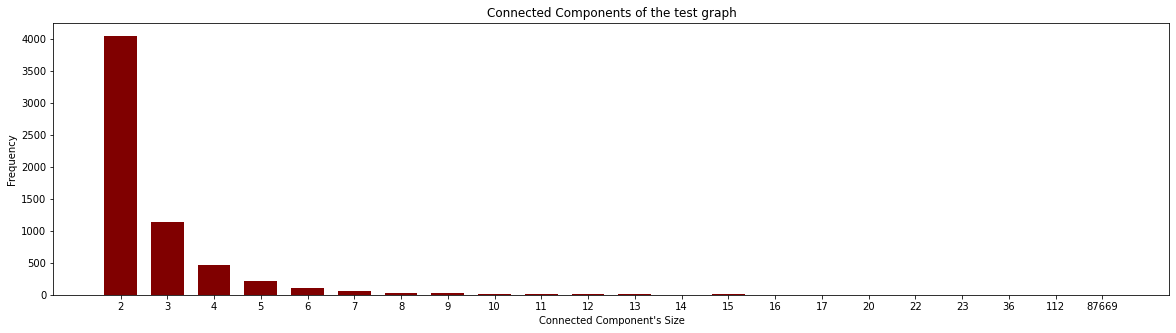

{2: 4049, 3: 1136, 4: 470, 5: 215, 6: 112, 7: 57, 8: 32, 9: 26, 10: 19, 11: 14, 12: 11, 13: 5, 14: 1, 15: 6, 16: 2, 17: 1, 20: 2, 22: 2, 23: 1, 36: 1, 112: 1, 87669: 1}


In [50]:
import numpy as np
import matplotlib.pyplot as plt

cc_size = list(map(str, list(cc_frequency.keys()))) 
cc_freq = list(cc_frequency.values())
  
fig = plt.figure(figsize = (20, 5))
 
# creating the bar plot
plt.bar(cc_size, cc_freq, color ='maroon', width = 0.7)
 
plt.xlabel("Connected Component's Size")
plt.ylabel("Frequency")
plt.title("Connected Components of the test graph")
plt.show()
print(cc_frequency)

### Node Degree Frequency

In [51]:
node_bar = dict(sorted(dict(nx_g.degree).items(), key=lambda x:x[1], reverse=True))

from itertools import islice
import collections

node_degree_frequency = dict(collections.Counter(list(node_bar.values())))
node_degree_frequency = dict(sorted(node_degree_frequency.items(), key=lambda x:x[0]))
print(node_degree_frequency)

{1: 76286, 2: 16319, 3: 4828, 4: 2059, 5: 1160, 6: 802, 7: 648, 8: 467, 9: 398, 10: 309, 11: 216, 12: 155, 13: 139, 14: 111, 15: 72, 16: 45, 17: 33, 18: 28, 19: 29, 20: 21, 21: 20, 22: 19, 23: 12, 24: 15, 25: 19, 26: 8, 27: 13, 28: 14, 29: 12, 30: 8, 31: 7, 32: 10, 33: 10, 34: 8, 35: 7, 36: 6, 37: 6, 38: 11, 39: 4, 40: 4, 41: 3, 42: 6, 43: 5, 44: 8, 45: 5, 46: 2, 47: 8, 48: 5, 49: 6, 50: 3, 51: 5, 52: 9, 53: 3, 54: 7, 55: 7, 56: 11, 57: 19, 58: 8, 59: 8, 60: 11, 61: 7, 62: 12, 63: 13, 64: 6, 65: 11, 66: 9, 67: 6, 68: 7, 69: 7, 70: 5, 71: 7, 72: 3, 74: 3, 75: 2, 76: 5, 77: 1, 78: 3, 80: 1, 81: 3, 82: 1, 84: 1, 87: 3, 88: 1, 91: 1, 92: 2, 105: 1, 106: 1, 107: 1, 111: 1, 112: 1, 118: 1, 121: 1, 123: 1, 125: 1, 127: 1, 132: 2, 134: 1, 137: 1, 142: 1, 147: 2, 151: 1, 163: 1, 166: 1, 176: 1, 194: 1, 242: 1, 278: 1, 305: 1, 307: 1, 309: 1, 312: 1, 355: 1, 387: 1, 418: 1, 451: 1, 478: 1, 489: 1, 578: 1, 592: 1, 826: 1, 925: 1, 1013: 1, 1136: 1, 13795: 1, 24301: 1, 30856: 1}


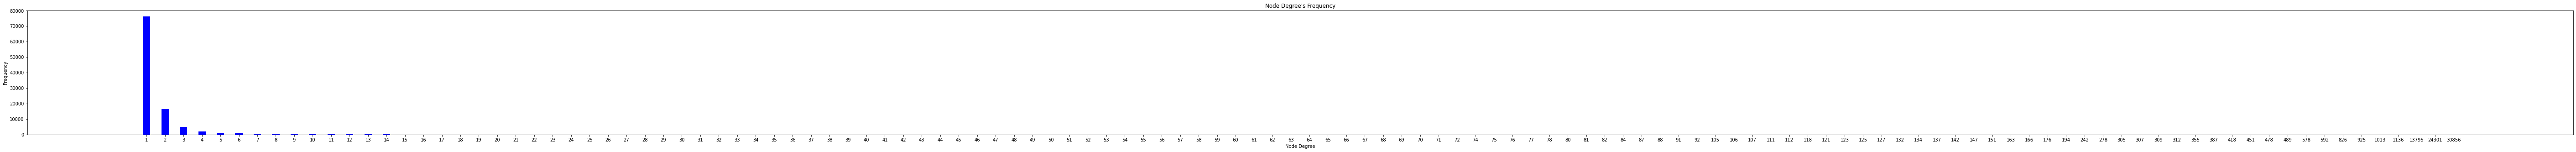

In [58]:
import numpy as np
import matplotlib.pyplot as plt

node_degree = list(map(str, list(node_degree_frequency.keys()))) 
node_degree_freq = list(node_degree_frequency.values())
  
fig = plt.figure(figsize = (100, 5))
 
# creating the bar plot
plt.bar(node_degree, node_degree_freq, color ='blue', width = 0.4)
 
plt.xlabel("Node Degree")
plt.ylabel("Frequency")
plt.title("Node Degree's Frequency")
plt.show()

### DataFrame

In [59]:
print(Test_Graph)
print(new_pred)
print(new_actual) # = Test_Graph.edata['label']

Graph(num_nodes=104640, num_edges=138050,
      ndata_schemes={'feature': Scheme(shape=(1, 76), dtype=torch.float32)}
      edata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 76), dtype=torch.float32)})
[1 1 0 ... 0 0 0]
[1 1 0 ... 0 0 0]


In [99]:
# 138050 edges
print(Test_Graph.edges())

(tensor([ 6444,  6444, 70375,  ..., 73434, 32319, 25791], device='cuda:0'), tensor([ 70375,  68097,  11453,  ...,  99923, 101037,  20714], device='cuda:0'))


In [101]:
print(nx_g_cc)

[{0, 104169, 2, 1}, {3, 13, 20, 25, 27, 28, 29, 31, 35, 36, 39, 43, 44, 49, 50, 55, 59, 63, 67, 71, 75, 76, 78, 80, 81, 88, 89, 90, 92, 100, 101, 103, 104, 106, 107, 110, 112, 113, 117, 118, 123, 124, 133, 136, 139, 149, 150, 152, 156, 158, 159, 164, 165, 166, 168, 169, 170, 171, 174, 175, 176, 178, 179, 181, 183, 184, 194, 196, 197, 199, 200, 205, 206, 207, 208, 210, 212, 214, 223, 227, 228, 229, 230, 231, 236, 238, 239, 241, 242, 244, 246, 253, 255, 256, 258, 259, 263, 265, 267, 271, 272, 273, 275, 277, 278, 279, 280, 281, 283, 285, 287, 288, 292, 293, 294, 295, 300, 305, 306, 311, 312, 313, 318, 321, 324, 331, 333, 335, 337, 339, 341, 343, 344, 346, 347, 349, 351, 352, 355, 356, 357, 358, 360, 361, 362, 366, 367, 369, 370, 373, 374, 375, 377, 380, 381, 383, 384, 387, 390, 391, 395, 396, 397, 406, 410, 411, 412, 419, 426, 428, 430, 435, 436, 437, 442, 447, 448, 451, 454, 456, 457, 458, 460, 461, 463, 464, 466, 468, 470, 471, 472, 475, 478, 480, 481, 482, 487, 489, 492, 494, 496, 498,

In [120]:
import pandas as pd

graph_data = pd.DataFrame(columns = ['Edge_ID', 'CC_Size', 'True_Label', 'Predicted_Label', 'Well_Predicted'])

In [121]:
src_nodes = Test_Graph.edges()[0]
# dst_nodes = Test_Graph.edges()[1]

for i, x in enumerate(src_nodes):
    for y in nx_g_cc:
        if x.item() in y :
            well_predicted = 1 if new_actual[i] == new_pred[i] else 0
            graph_data.loc[-1] = [i, len(y), new_actual[i], new_pred[i], well_predicted]  # adding a row
            graph_data.index = graph_data.index + 1  # shifting index
            # print(i, x.item())
            break

In [122]:
print(graph_data)
print(len(graph_data))

        Edge_ID  CC_Size  True_Label  Predicted_Label  Well_Predicted
138049        0    87669           1                1               1
138048        1    87669           1                1               1
138047        2    87669           0                0               1
138046        3    87669           0                0               1
138045        4    87669           0                0               1
...         ...      ...         ...              ...             ...
4        138045    87669           0                0               1
3        138046        2           0                0               1
2        138047        3           0                0               1
1        138048        2           0                0               1
0        138049    87669           0                0               1

[138050 rows x 5 columns]
138050


In [123]:
graph_data.to_csv(f'/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/Test_Graph_Analysis.csv', sep=',', index = False)

In [128]:
graph_data_test = pd.read_csv('/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/Test_Graph_Analysis.csv', encoding="ISO-8859–1", dtype = str)
graph_data_test = graph_data_test.apply(pd.to_numeric)
print(graph_data_test.dtypes)

Edge_ID            int64
CC_Size            int64
True_Label         int64
Predicted_Label    int64
Well_Predicted     int64
dtype: object


In [131]:
pred_erros = graph_data_test.loc[graph_data_test['Well_Predicted'] == 0]
print(pred_erros)

        Edge_ID  CC_Size  True_Label  Predicted_Label  Well_Predicted
3495       3495    87669           0                1               0
3825       3825    87669           1                0               0
3884       3884    87669           1                0               0
4535       4535    87669           1                0               0
6181       6181    87669           0                1               0
...         ...      ...         ...              ...             ...
137489   137489    87669           0                1               0
137585   137585    87669           0                1               0
137915   137915    87669           0                1               0
137984   137984    87669           0                1               0
137995   137995    87669           0                1               0

[1440 rows x 5 columns]
